In [1]:
import torch
torch.cuda.is_available()
print(torch.zeros(1).cuda())

/home/asd27/.conda/envs/cudatorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensor([0.], device='cuda:0')


In [2]:
import torch
import torch_geometric
import torch_geometric.nn as pyg_nn
from torch_sparse import SparseTensor, matmul
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
print(torch_geometric.__version__)

import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType, OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

import networkx as nx
from deepsnap.hetero_graph import HeteroGraph
import copy
from copy import deepcopy
import pickle

import deepsnap
from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from deepsnap.hetero_gnn import forward_op
from deepsnap.hetero_graph import HeteroGraph
from sklearn.metrics import f1_score, roc_auc_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import json
from pathlib import Path as Data_Path
from os import listdir
from os.path import isfile, join
from itertools import combinations
from tqdm.notebook import tqdm

2.1.0


In [3]:
import graph_tool.all as gt
import json
print("graph-tool version: {}".format(gt.__version__.split(' ')[0]))

graph-tool version: 2.46


In [26]:
f = open('./mpd.slice.0-999.json')
data1 = json.load(f)
print(type(data1))

<class 'dict'>


In [5]:
f2 = open('./mpd.slice.1000-1999.json')
data2 = json.load(f2)
print(type(data2))

<class 'dict'>


In [7]:
def json2graph(g, data_json):
    
    # g = gt.Graph(directed=False)
    #playlist attributes
    g.vp['pl_name'] = g.new_vertex_property('string')
    g.vp['pl_type'] = g.new_vertex_property('string')
    #track attributes
    g.vp['tr_uri'] = g.new_vertex_property('string')
    g.vp['tr_name'] = g.new_vertex_property('string')
    g.vp['tr_type'] = g.new_vertex_property('string')
    #artist attibutes
    # g.vp['ar_uri'] = g.new_vertex_property('string')
    # g.vp['ar_name'] = g.new_vertex_property('string')
    # g.vp['ar_type'] = g.new_vertex_property('string')
    
    #add playlist nodes
    playlist_len=len(data_json['playlists'])
    playlist_attrs = []
    for playlist in data_json['playlists']:
        playlist_attrs.append({'pl_name': playlist['name'], 'pl_type': 'playlist'})
 
    for node_attrs in playlist_attrs:
        v1 = g.add_vertex()
        for key, value in node_attrs.items():
            g.vp[key][v1] = value
            
    #add track nodes
    track_attrs = []
    # artist_attrs = []
    playlist_index=0
    edge_index=playlist_len
    # artist_edge_list=[]
    playlist_edge_list=[]
    track_index_dict={}
    # artist_track_dict={}
                               
    for playlist in data_json['playlists']:
        tracks_list = playlist['tracks']
        for track in tracks_list:
            dict_track={'tr_uri': track['track_uri'], 'tr_name': track['track_name'], 'tr_type': 'track'}
            if dict_track not in track_attrs:
                track_attrs.append(dict_track)
                track_index_dict[track['track_uri']]=edge_index
                edge_index+=1
            # dict_artist={'ar_uri': track['artist_uri'], 'ar_name': track['artist_name'], 'ar_type': 'artist'}
            # if dict_artist not in artist_attrs:
            #     artist_attrs.append(dict_artist)
            #     if track['artist_uri'] in artist_track_dict:
            #         artist_track_dict[track['artist_uri']].add(track['track_uri'])
            #     else:
            #         artist_track_dict[track['artist_uri']]={track['track_uri']}
            playlist_edge_list.append((playlist_index,edge_index))
            
        playlist_index+=1
 
    for node_attrs in track_attrs:
        v2 = g.add_vertex()
        for key, value in node_attrs.items():
            g.vp[key][v2] = value

    # artist_index=edge_index
    # for node_attrs in artist_attrs:
    #     v3 = g.add_vertex()
    #     for track in artist_track_dict[node_attrs['ar_uri']]:
    #         artist_edge_list.append((artist_index,track_index_dict[track]))
    #     for key, value in node_attrs.items():
    #         g.vp[key][v3] = value
    #     artist_index+=1
    # g.add_edge_list(artist_edge_list)
    g.add_edge_list(playlist_edge_list)
    
    # return g

# def append_graphs(g1, g2):
#     # Get the last vertex index from g1
#     last_vindex = g1.num_vertices() - 1

#     # Get vertex properties from g1
#     vp1 = {key: g1.vp[key] for key in g1.vertex_properties.keys()}

#     # Add vertex properties to g2
#     for key, value in vp1.items():
#         g2.vp[key] = g2.new_vertex_property(value.value_type())

#     # Append vertices from g1 to g2 with new index
#     for v in g1.vertices():
#         new_v = g2.add_vertex()
#         for key, value in vp1.items():
#             g2.vp[key][new_v] = value[v]
        

In [27]:
g1 = gt.Graph(directed=False)
json2graph(g1, data1)
print("Number of vertices:", g1.num_vertices())
print("Number of edges:", g1.num_edges())

Number of vertices: 35444
Number of edges: 67503


In [48]:
json2graph(g1, data2)
print("Number of vertices:", g1.num_vertices())
print("Number of edges:", g1.num_edges())

Number of vertices: 72619
Number of edges: 134125


In [8]:
# #with artists
# json2graph(g1, data2)
# print("Number of vertices:", g1.num_vertices())
# print("Number of edges:", g1.num_edges())

Number of vertices: 92675
Number of edges: 154182


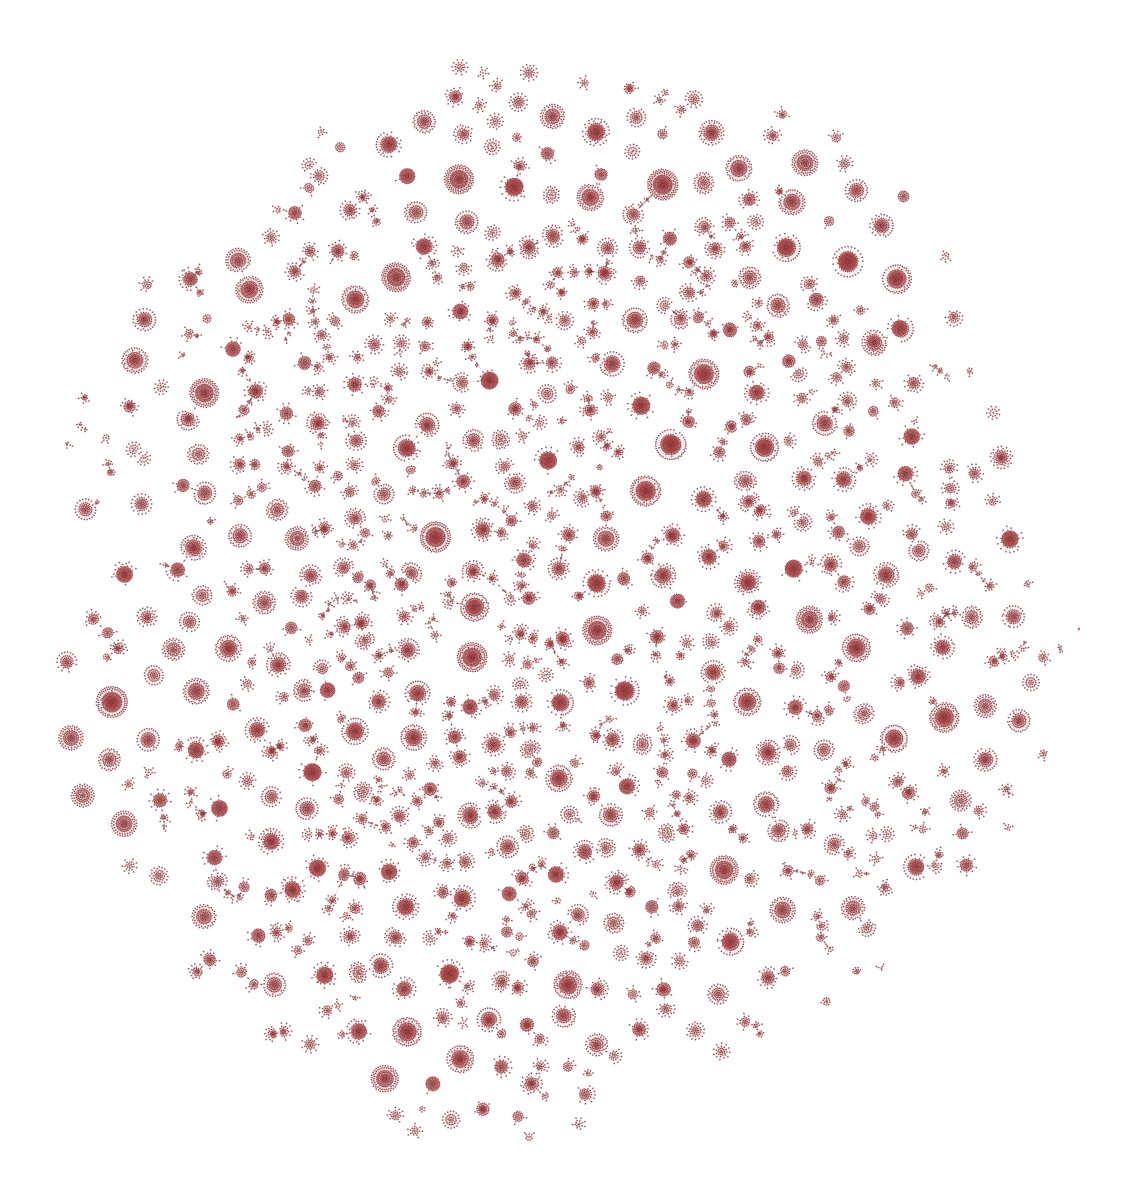

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7ff3824dd6d0, at 0x7ff38be63d10>

In [31]:
gt.graph_draw(G)

In [54]:
# gt.graph_draw(g1)

In [ ]:
for v in G.vertices():
    print("Node", int(v), "has attrs:")
    for prop in G.vertex_properties:
        print("  -", prop, ":", G.vertex_properties[prop][v])

In [28]:
with open("initial_graph.pickle", "wb") as f:
    pickle.dump(g1, f)

### preprocessing

In [29]:
with open("initial_graph.pickle", "rb") as f:
    loaded_graph = pickle.load(f)

In [30]:
print("Number of vertices:", loaded_graph.num_vertices())
print("Number of edges:", loaded_graph.num_edges())

Number of vertices: 35444
Number of edges: 67503


In [31]:
labels, hist = gt.label_components(loaded_graph)

# Get the label of the largest component
largest_label = labels[np.argmax(hist)]

# Extract the largest component as a subgraph
largest_component = gt.GraphView(loaded_graph, vfilt=labels.a == largest_label)

print("Number of vertices:", largest_component.num_vertices())
print("Number of edges:", largest_component.num_edges())

Number of vertices: 138
Number of edges: 161


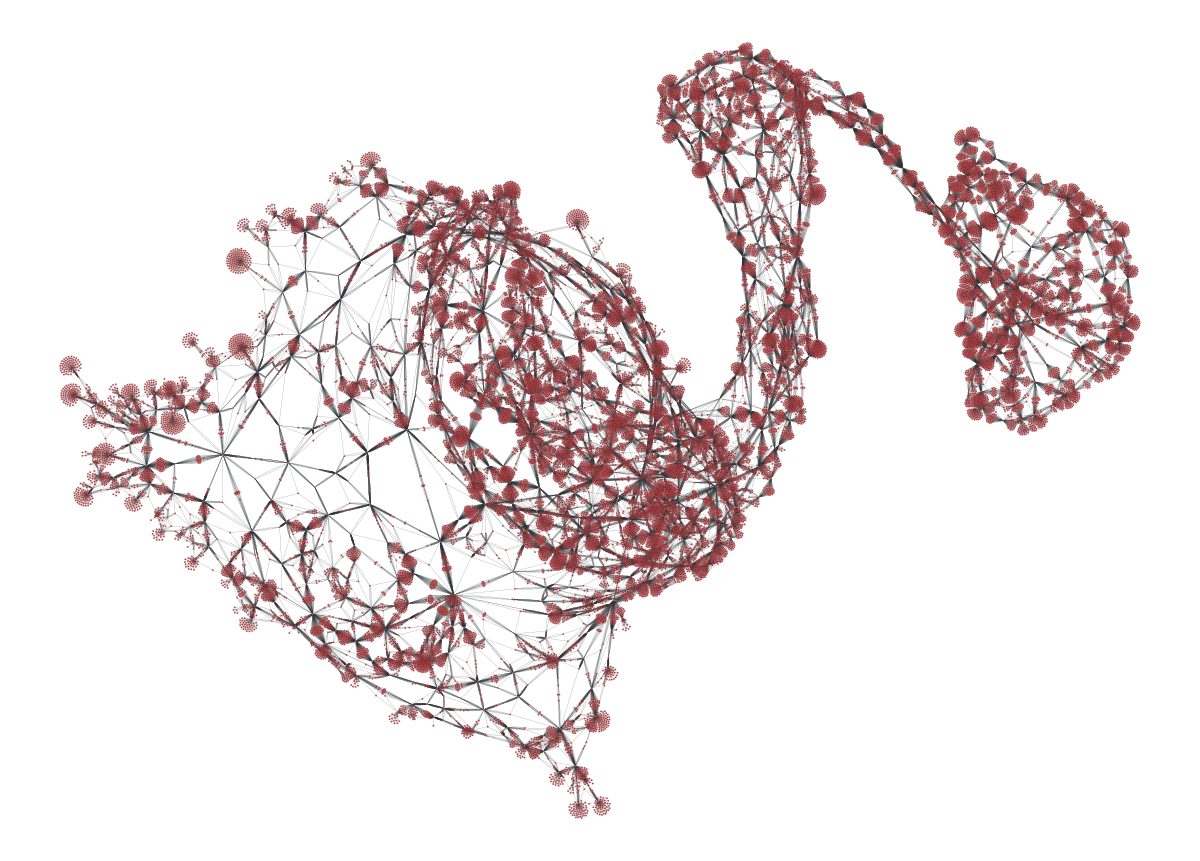

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fb8826d4e10, at 0x7fb8a45d7e90>

In [31]:
gt.graph_draw(largest_component)

In [32]:
count_pl = sum(1 for v in largest_component.vertices() if largest_component.vp.pl_type[v] == "playlist")
print(f'num_playlists: {count_pl}')
count_tr = sum(1 for v in largest_component.vertices() if largest_component.vp.tr_type[v] == "track")
print(f'num_tracks: {count_tr}')

num_playlists: 1
num_tracks: 137


In [56]:
count_ar = sum(1 for v in largest_component.vertices() if largest_component.vp.ar_type[v] == "artist")
print(f'num_tracks: {count_ar}')

num_tracks: 0


### graph creation with 50 mpd files

In [8]:
import os
folder_path = "../data/"

file_paths = []
for root, dirs, files in os.walk(folder_path):
    for file in files:
        file_paths.append(os.path.join(root, file))

In [9]:
# file_paths

In [10]:
final_graph = gt.Graph(directed=False)

for file in file_paths:
    f = open(file)
    data = json.load(f)
    json2graph(final_graph, data)
    print(f'file {file} processed')

file ../data/mpd.slice.30000-30999.json processed
file ../data/mpd.slice.31000-31999.json processed
file ../data/mpd.slice.32000-32999.json processed
file ../data/mpd.slice.33000-33999.json processed
file ../data/mpd.slice.34000-34999.json processed
file ../data/mpd.slice.35000-35999.json processed
file ../data/mpd.slice.36000-36999.json processed
file ../data/mpd.slice.37000-37999.json processed
file ../data/mpd.slice.38000-38999.json processed
file ../data/mpd.slice.39000-39999.json processed
file ../data/mpd.slice.4000-4999.json processed
file ../data/mpd.slice.40000-40999.json processed
file ../data/mpd.slice.41000-41999.json processed
file ../data/mpd.slice.42000-42999.json processed
file ../data/mpd.slice.43000-43999.json processed
file ../data/mpd.slice.44000-44999.json processed
file ../data/mpd.slice.45000-45999.json processed
file ../data/mpd.slice.46000-46999.json processed
file ../data/mpd.slice.47000-47999.json processed
file ../data/mpd.slice.48000-48999.json processed
fi

In [34]:
print("Number of vertices:", final_graph.num_vertices())
print("Number of edges:", final_graph.num_edges())

Number of vertices: 2738704
Number of edges: 5069383


In [23]:
count_pl = sum(1 for v in final_graph.vertices() if final_graph.vp.pl_type[v] == "playlist")
print(f'num_playlists: {count_pl}')
count_tr = sum(1 for v in final_graph.vertices() if final_graph.vp.tr_type[v] == "track")
print(f'num_tracks: {count_tr}')

num_playlists: 1000
num_tracks: 36656


In [17]:
with open("final_graph.pickle", "wb") as f:
    pickle.dump(final_graph, f)
    pickle.dump(final_graph.vp["pl_name"].a, f)
    pickle.dump(final_graph.vp["pl_type"].a, f)
    pickle.dump(final_graph.vp["tr_uri"].a, f)
    pickle.dump(final_graph.vp["tr_name"].a, f)
    pickle.dump(final_graph.vp["tr_type"].a, f)

In [20]:
a = final_graph.vp["tr_name"].a
print(a)

None


In [33]:
final_graph.vp["pl_name"].a

In [36]:
print(final_graph.vertex_properties)

{'pl_name': <VertexPropertyMap object with value type 'string', for Graph 0x7f59d79c6310, at 0x7f59d8849a10>, 'pl_type': <VertexPropertyMap object with value type 'string', for Graph 0x7f59d79c6310, at 0x7f59d8bbb110>, 'tr_uri': <VertexPropertyMap object with value type 'string', for Graph 0x7f59d79c6310, at 0x7f5b82e97590>, 'tr_name': <VertexPropertyMap object with value type 'string', for Graph 0x7f59d79c6310, at 0x7f59d8bb9e10>, 'tr_type': <VertexPropertyMap object with value type 'string', for Graph 0x7f59d79c6310, at 0x7f59ea0e3a50>}


In [ ]:
#todo: 
# 1. remove artist nodes (check implementation before commenting) --DONE
# 2. 3-hop neighborhood

In [43]:
print(final_graph.vp["pl_name"].a)

None


In [ ]:
vp1 = final_graph.vp["pl_name"]
for v in final_graph.vertices():
    prop_value = vp1[v]
    print(type(prop_value))

In [ ]:
)